In [5]:
%load_ext autoreload
%autoreload 2

## Background

### ABQ CURRENT POLICY

- New Mexico emissions tests must be performed on all Bernalillo County vehicles 35 years old and newer.
- All diesel vehicles are exempt from emissions testing.
- Vehicles weighing more than 10,000 lbs do not require an emissions test.
- Any vehicle (including gas-electric hybrid vehicles) must pass an emissions test every two years, or any time the vehicle’s ownership changes, even if the emissions inspection sticker has not yet expired.
- Motorcycles, ATV’s, boats, and scooters do not require an emissions test.

### ABQ CURRENT EMISSIONS TESTING INCLUDES:

- Pollution control equipment check that includes the catalytic converter and other connections.
- On-Board Diagnostic (OBDII) computer car emission test on vehicles 1996 and newer.
- Any visible car smoke test to uncover burning oil or poor fuel combustion that results in toxic emissions.
- Gas cap check to search for vapor leaks.
- Tailpipe exhaustion analysis on vehicles manufactured between 1983 and 1995.

### ABQ Failed Emissions Test Resource Center
- The Vehicle Pollution Management Division (VPMD) offers one free retest for vehicles that do not pass an emissions test within 90 days of the failed test date

## Organizing some thoughts

### Is our preliminary system promising?
Let's look at 2020 and how it would be different with our preliminary system

#### importing data and split train (before 2020) and test (2020) set

In [1]:
from emissions.data import load_data, clean_data
df = load_data()
df_all = clean_data(df)

----------------start loading data----------------
Data loaded: 187503 records
----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records with missing GVWR: 8125

Records after droping rows where GVWR is < 1000 or missing: 179373

Records after keeping only the earliest test within a month for each vehicle: 165732

Records where ODOMETER = 0: 796

Records after droping rows where ODOMETER is missing: 164855

Records after droping rows where MILE_YEAR > 40,000: 163891

Records in output data:163891

Share of Pass and Fail after cleaning:
Fail: 7%
Pass: 93%

Unique vehicles in Fail: 10194
Unique vehicles in Pass: 78573
['VEHICLE_TYPE' 'MODEL_YEAR' 'VEHICLE_AGE' 'MILE_YEAR' 'GVWR'
 'ENGINE_SIZE' 'TRANS_TYPE' 'TEST_TYPE' 'RESULT' 'MAKE'
 'ENGINE_WEIGHT_RATIO' 'SPORT' 'TEST_SDATE']


In [2]:
df.head()

,VEHICLE_TYPE,MODEL_YEAR,VEHICLE_AGE,MILE_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,TEST_TYPE,RESULT,MAKE,ENGINE_WEIGHT_RATIO,SPORT,TEST_SDATE
0,3,2011,4,3637.25,6700.0,3700,A,I,0,dodge,0.55,0,2013-01-02 07:46:00
1,1,2002,13,12142.85,3125.0,2000,A,I,0,acura,0.64,0,2013-01-02 08:58:00
2,1,2001,14,12862.07,3875.0,2300,A,I,1,saab,0.59,0,2013-01-02 09:09:00
3,1,1996,19,7041.84,3625.0,3000,A,I,0,mercury,0.83,0,2013-01-02 09:10:00
4,1,2008,7,16336.71,2750.0,1600,A,I,0,chevrolet,0.58,0,2013-01-02 09:15:00


In [3]:
# train < 2020 test 2020 split 
df_all['count_test'] = 1
df_all['count_fail'] = df_all.RESULT
train = df_all[df_all.TEST_SDATE.dt.year < 2020].sort_values('TEST_SDATE')
test = df_all[df_all.TEST_SDATE.dt.year == 2020].sort_values('TEST_SDATE')
y_train = train.pop('RESULT')
X_train = train
y_test = test.pop('RESULT')
X_test = test
X_train.shape, y_train.shape

((142916, 14), (142916,))

#### recall or precision?



57 make labels each account for less than 1.0% of cars and together account for 9.17% of cars


,train,val,test
accuracy,0.575,0.576,0.591
recall,0.750,0.746,0.731
precision,0.116,0.116,0.109


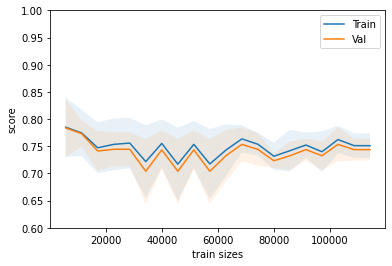

In [4]:
# best estimator with recall
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE']
from emissions.trainer import Trainer
trainer = Trainer(X_train[cols], y_train)
trainer.grid_search()
tmp = trainer.evaluate(X_test[cols], y_test)
print(trainer.search_result.best_params_)
trainer.learning_curve()
tmp


57 make labels each account for less than 1.0% of cars and together account for 9.17% of cars


,train,val,test
accuracy,0.633,0.631,0.623
recall,0.736,0.724,0.725
precision,0.131,0.129,0.117


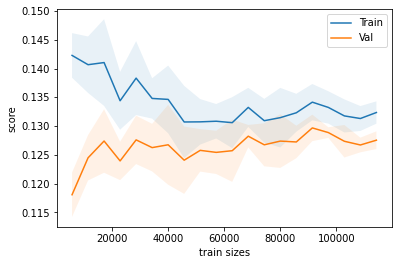

In [27]:
# best estimator with precision
cols = ['VEHICLE_AGE', 'MILE_YEAR', 'MAKE']
from emissions.trainer import Trainer
trainer2 = Trainer(X_train[cols], y_train, metric='precision', grid = {'model__max_depth': np.arange(2, 7, 1)})
trainer2.grid_search()
tmp2 = trainer2.evaluate(X_test[cols], y_test)
print(trainer2.search_result.best_params_)
trainer2.learning_curve()
tmp2

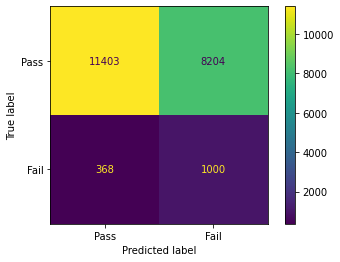

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trainer.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

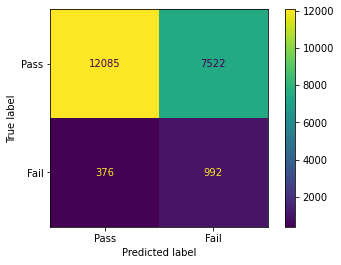

In [29]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(trainer2.search_result.best_estimator_, X_test[cols], y_test, display_labels=["Pass", "Fail"])

In [54]:
total_test = X_test.shape[0]
n_fail_2020 = 1368
# best estimator with recall
precision1 = 0.109
n_fail_pred1 = 9204
n_fail_captured1 = 1000
# best estimator with precision
precision2 = 0.117
n_fail_pred2 = 8514
n_fail_captured2 = 992

In [73]:
total_test

20975

In [55]:
# create cum_tests and cum_fails columns
df = X_test[['TEST_SDATE', 'count_fail', 'count_test']].copy()
df.set_index('TEST_SDATE', inplace=True)
df['n_test'] = df.count_test.cumsum()
df['n_fail'] = df.count_fail.cumsum()
df.drop(columns=['count_test', 'count_fail'], inplace=True)
df.head()

,n_test,n_fail
TEST_SDATE,,
2020-01-01 09:52:37,1,0
2020-01-01 13:44:43,2,0
2020-01-01 15:32:25,3,0
2020-01-01 15:51:44,4,0
2020-01-02 08:11:22,5,0


In [56]:
# define a function to create number of fails captured along 2020 with our solution

def create_n_fail(data, precision, n_fail_pred, n_fail_captured):
    """ 
    takes a df with n_test and n_fail columns, 
    precision: precision score on 2020 test set
    n_fail_pred: number of fails predicted for 2020
    n_fail_captures: number of predicted fails that are true fails
    returns a panda series: number of fails captured along the time
    """
    df = data.copy()
    col = 'n_fail_cap'
    # first test all the predicted fails
    df[col] = df.n_test * precision

    # changes after finish testing predicted fails
    tests_left = df[df.n_test > n_fail_pred].shape[0]
    fails_left = n_fail_2020 - n_fail_captured
    avg_fail_per_test = fails_left/tests_left
    df.loc[df.n_test > n_fail_pred, col] = \
        n_fail_captured + (df[df.n_test > n_fail_pred]['n_test'] - n_fail_pred)*avg_fail_per_test

    # changes after capturing all the true fails
    df.loc[df[col] > n_fail_2020, col] = n_fail_2020
    return df[col]

df['n_fail_recall'] = create_n_fail(df, precision1, n_fail_pred1, n_fail_captured1)
df['n_fail_precision'] = create_n_fail(df, precision2, n_fail_pred2, n_fail_captured2)
df.head()

,n_test,n_fail,n_fail_recall,n_fail_precision
TEST_SDATE,,,,
2020-01-01 09:52:37,1,0,0.109,0.117
2020-01-01 13:44:43,2,0,0.218,0.234
2020-01-01 15:32:25,3,0,0.327,0.351
2020-01-01 15:51:44,4,0,0.436,0.468
2020-01-02 08:11:22,5,0,0.545,0.585


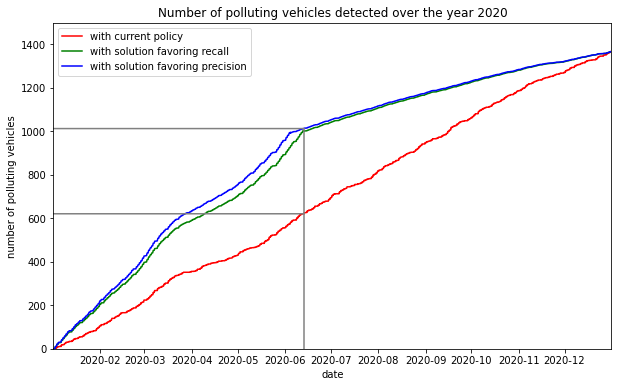

In [72]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.n_fail, label='with current policy', c='red')
plt.plot(df.index, df.n_fail_recall, label='with solution favoring recall', c='green')
plt.plot(df.index, df.n_fail_precision, label='with solution favoring precision', c='blue')
t0 = df[df.n_test==n_fail_pred1].index[0]
n_fails_precision_t0 = df[df.index==t0].n_fail_precision[0]
n_fails_t0 = df[df.index==t0].n_fail[0]
plt.plot([t0 for i in range(100)], np.linspace(0, n_fails_precision_t0, 100), c='grey')
plt.plot(df[df.index < t0].index, [n_fails_precision_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.plot(df[df.index < t0].index, [n_fails_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.ylim(0, 1500)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('number of polluting vehicles')
plt.xlabel('date')
plt.legend()
plt.title('Number of polluting vehicles detected over the year 2020');

Whether to use recall or precision is a decision of ours not our clients.

#### How different 2020 could have been?

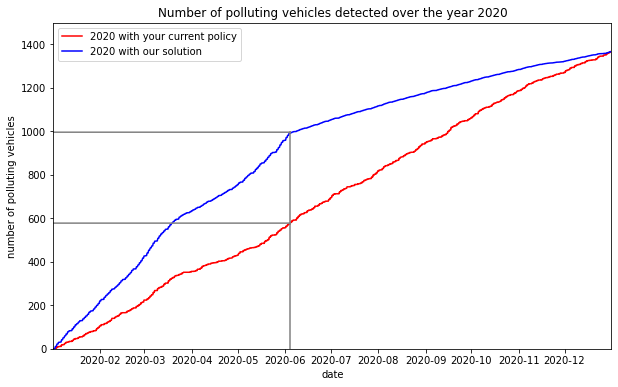

In [70]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index, df.n_fail, label='2020 with your current policy', c='red')
plt.plot(df.index, df.n_fail_precision, label='2020 with our solution', c='blue')
t0 = df[df.n_test==n_fail_pred2].index[0]
n_fails_precision_t0 = df[df.index==t0].n_fail_precision[0]
n_fails_t0 = df[df.index==t0].n_fail[0]
plt.plot([t0 for i in range(100)], np.linspace(0, n_fails_precision_t0, 100), c='grey')
plt.plot(df[df.index < t0].index, [n_fails_precision_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.plot(df[df.index < t0].index, [n_fails_t0 for i in range(df[df.index < t0].shape[0])], c='grey')
plt.ylim(0, 1500)
plt.xlim(df.index.min(), df.index.max())
plt.ylabel('number of polluting vehicles')
plt.xlabel('date')
plt.legend()
plt.title('Number of polluting vehicles detected over the year 2020');

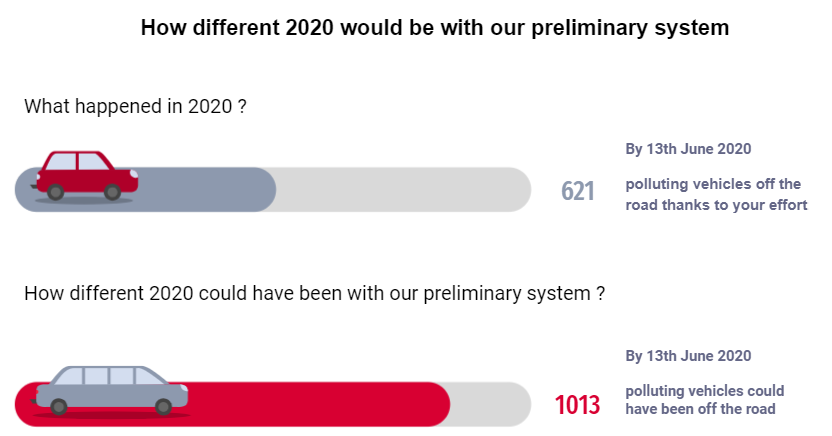
